# Автоэнкодеры

## 1. Подход 

Автоэнкодеры - unsupervised (не требующие разметки данных) модели, которые находят применение как важные строительные блоки в огромном кол-ве сложных моделей и подходов.

Идея автоэнкодера крайне проста - он состоит из двух нейронных сетей, называемых _энкодером_ и _декодером_, которые работают в тандеме. Задача энкодера - сжать исходный объект до вектора малой размерности, называемого _латентным кодом_ (или _скрытым представлением_). Задача декодера - восстановить из этого латентного кода исходный объект. 

![Архитектура автоэнкодера](https://miro.medium.com/max/600/1*nqzWupxC60iAH2dYrFT78Q.png)

Источник картинки: [medium](https://medium.com/@birla.deepak26/autoencoders-76bb49ae6a8f)


Обучение происходит путем уменьшения ошибки между исходным объектом и восстановленным:

$$ \operatorname{Loss} = \sum \operatorname{MSE}(x_i, dec(enc(x_i))) $$

In [1]:
from pathlib import Path

from tqdm.notebook import tqdm

import numpy as np

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
%matplotlib inline

from IPython.display import clear_output

## 2. Пишем простой автоэнкодер для MNIST

Начнём со скачивания датасета.

In [2]:
from torch.hub import _get_torch_home

data_root = Path(_get_torch_home()) / 'datasets'

transform = transforms.Compose([
    transforms.ToTensor(),
])

dataset_train = torchvision.datasets.MNIST(root=data_root, train=True, download=True, transform=transform)
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=64, shuffle=True, num_workers=1)

dataset_valid = torchvision.datasets.MNIST(root=data_root, train=False, download=True, transform=transform)
dataloader_valid = torch.utils.data.DataLoader(dataset_valid, batch_size=64, shuffle=False, num_workers=1)

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting /root/.cache/torch/datasets/MNIST/raw/train-images-idx3-ubyte.gz to /root/.cache/torch/datasets/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting /root/.cache/torch/datasets/MNIST/raw/train-labels-idx1-ubyte.gz to /root/.cache/torch/datasets/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting /root/.cache/torch/datasets/MNIST/raw/t10k-images-idx3-ubyte.gz to /root/.cache/torch/datasets/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting /root/.cache/torch/datasets/MNIST/raw/t10k-labels-idx1-ubyte.gz to /root/.cache/torch/datasets/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Давайте реализуем и поиграемся с простым автоэнкодером, который берет изображения из MNIST и кодирует их в латентные коды длины `k`. В этом задании надо реализовать:

* Encoder
    * Четырехслойная полносвязная сеть с размерами слоёв `784-128-64-32-k`
* Decoder
    * Симметричная полносвязная сеть с размерами слоёв `k-32-64-128-784` **и сигмоида в конце**

In [3]:
!nvidia-smi

Wed Jun  9 18:06:56 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [11]:
class MNISTEncoder(nn.Module):
    def __init__(self, lat_size):
        super(MNISTEncoder, self).__init__()
        self.lat_size = lat_size
        
        # Подсказка: пригодится nn.Flatten()
        self.enc_net = nn.Sequential(
            # 784-128-64-32-k
            nn.Flatten(),
            nn.Linear(28 * 28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, lat_size),
        )
        
    def forward(self, x):
        assert len(x.shape) == 4
        assert x.shape[2] == x.shape[3] == 28
        
        z = self.enc_net(x)
        
        assert z.shape[0] == x.shape[0]
        assert z.shape[1] == self.lat_size
        
        return z
    
class MNISTDecoder(nn.Module):
    def __init__(self, lat_size):
        super(MNISTDecoder, self).__init__()
        self.lat_size = lat_size
        
        # Подсказка: пригодится nn.Unflatten() (посмотрите документацию!)
        self.dec_net = nn.Sequential(
            # k-32-64-128-784 и сигмоида в конце
            nn.Linear(lat_size, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28 * 28),
            nn.Unflatten(1, (1, 28, 28)),
            nn.Sigmoid(),
        )
        
    def forward(self, z):
        assert z.shape[1] == self.lat_size
        
        x_rec = self.dec_net(z)
        
        assert x_rec.shape[1:] == (1, 28, 28)
        assert x_rec.shape[0] == z.shape[0]
        
        return x_rec

In [12]:
class AutoEncoder(nn.Module):
    def __init__(self, lat_size):
        super(AutoEncoder, self).__init__()
        
        self.lat_size = lat_size
        self.enc = MNISTEncoder(lat_size)
        self.dec = MNISTDecoder(lat_size)
        
    def encode(self, x):
        return self.enc(x)
    
    def decode(self, z):
        return self.dec(z)

    def forward(self, x):
        return self.dec(self.enc(x))

Теперь давайте обучим автоэнкодер:

In [13]:
def train_model(model, dataloader_train, optimizer, criterion, num_epochs=5, verbose_num_iters=32):
    model.train()
    loss_trace = []
    
    for epoch_i in range(num_epochs):        
        print(f'Epoch {epoch_i + 1}')
        for iter_i, batch in enumerate(dataloader_train):
            x, _ = batch
            x = x.to(device)

            rec_x = model(x)
            loss = criterion(rec_x, x)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            loss_trace.append(loss.item())
        
            if (iter_i + 1) % verbose_num_iters == 0:
                clear_output(wait=True)
                plt.figure(figsize=(10, 5))
                
                plt.subplot(1, 2, 1)
                plt.xlabel('Iteration')
                plt.ylabel('L2 loss (x, x_rec)')
                plt.plot(loss_trace)
                
                for i in range(3):
                    plt.subplot(2, 6, 4 + i)
                    plt.axis('off')
                    plt.imshow(x[i, 0].cpu().detach().numpy(), cmap='gray')
                    
                    plt.subplot(2, 6, 10 + i)
                    plt.axis('off')
                    plt.imshow(rec_x[i, 0].cpu().detach().numpy(), cmap='gray')
                    
                plt.show()
                
    model.eval()

В качестве лосса будем использовать сумму квадратов разностей пикселей оригинального и восстановленного изображения. 

In [14]:
criterion = nn.MSELoss()

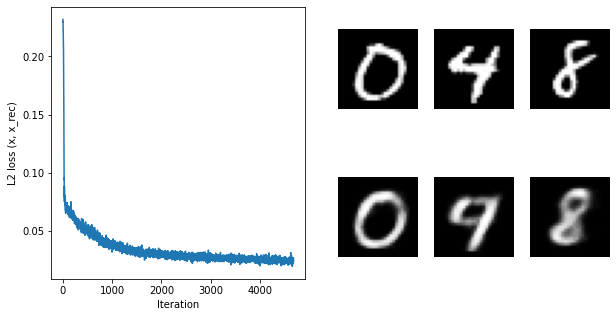

In [15]:
# обучим модель с латентным кодом длины 8

model = AutoEncoder(8)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

train_model(model, dataloader_train, optimizer, criterion)

Для довольно хорошего сжатия картинок из MNIST'a хватает всего 8 латентных переменных!

## 3. Структура и интерпретация латентного пространства

Главная ценность автоэнкодера как модели - его латентный код. Он крайне информативный, т.к. он должен сохранять как можно больше важных деталей об объекте. Кроме того, само латентное пространство (множество латентных кодов всех объектов) - довольно плотное и отлично сохраняет структуру исходного пространства - например, похожие объекты в исходном пространстве будут находиться недалеко друг от друга в латентном. 

В этой части мы проиллюстрируем эти свойства.

### 3.1 Интерполяция латентных кодов

Интерполяция латентного кода - это визуализация процесса движения от одной точки латентного пространства к другой. Обычно интерполируют по прямой - соединяют две точки, соответсвующие реальным объектам, отрезком и смотрят латентные коды через равные части этого отрезка. Для каждой промежуточной точки строят выход декодера. 

Давайте возьмем два случайных объекта из выборки и построим интерполяцию между ними.

In [16]:
for x, _ in dataloader_train:
    break

x1 = x[0].to(device)
x2 = x[1].to(device)

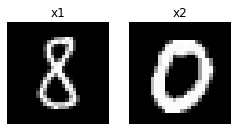

In [17]:
plt.figure(figsize=(4, 2))

plt.subplot(1, 2, 1)
plt.axis('off')
plt.title('x1')
plt.imshow(x1[0].cpu().detach().numpy(), cmap='gray')

plt.subplot(1, 2, 2)
plt.axis('off')
plt.title('x2')
plt.imshow(x2[0].cpu().detach().numpy(), cmap='gray')

In [18]:
torch.linspace(0, 1, 11)

tensor([0.0000, 0.1000, 0.2000, 0.3000, 0.4000, 0.5000, 0.6000, 0.7000, 0.8000,
        0.9000, 1.0000])

In [19]:
# получите латентные коды объектов
z_1 = model.encode(x1.unsqueeze(dim=0))
z_2 = model.encode(x2.unsqueeze(dim=0))
assert z_1.shape == z_2.shape == torch.Size([1, 8])

# постройте батч с интерполяцией этих латентных кодов по прямой в 11 точках (используйте функцию torch.linspace)
linspace = torch.linspace(0, 1, 11, device=device).unsqueeze(dim=1)  # shape: 11x1
z_linspace = z_1 * (1 - linspace) + z_2 * linspace
assert z_linspace.shape == torch.Size([11, 8])

# восстановите для всех латентных кодов изображения
x_linspace = model.decode(z_linspace)
assert x_linspace.shape == torch.Size([11, 1, 28, 28])

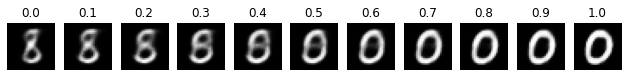

In [20]:
# нарисуем проинтерполированные объекты
plt.figure(figsize=(11, 1))

for i, d in enumerate(np.linspace(0, 1, 11)):
    plt.subplot(1, 11, i + 1)
    plt.axis('off')
    plt.title(f'{d:.2}')
    plt.imshow(x_linspace[i, 0].cpu().detach().numpy(), cmap='gray')

На интерполяции видно, как один объект плавно превращается в другой. Стоит заметить, что почти все промежуточные объекты тоже выглядят довольно правдопободно. Иногда такие интерполяции используют для того, чтобы расширить какой-то маленький датасет.

### 3.2 Структура латентного пространства

Теперь давайте обучим автоэнкодер с **2** латентными кодами, соберем эти латентные коды и нарисуем 2D scatter plot, где латентные коды подсвечены цветами классов исходных объектов.

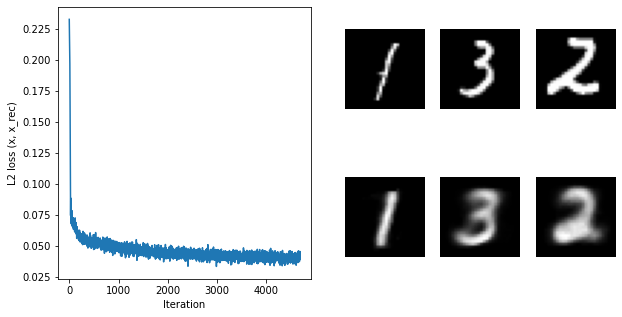

In [21]:
# обучим автоэнкодер с 2 латентными кодами

model_2d = AutoEncoder(2)
model_2d.to(device)
optimizer = torch.optim.Adam(model_2d.parameters(), lr=1e-3)

train_model(model_2d, dataloader_train, optimizer, criterion)

In [23]:
def get_latent_codes_and_labels(dataloader, model, num_objects):
    lat_codes = torch.empty((0, model.lat_size)).to(device)
    labels = torch.empty((0)).to(device)

    with torch.no_grad():
        for x_batch, y_batch in dataloader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            
            lat_code = model.encode(x_batch)

            lat_codes = torch.cat([lat_codes, lat_code], dim=0)
            labels = torch.cat([labels, y_batch], dim=0)
        
            if lat_codes.shape[0] >= num_objects:
                break

    lat_codes = lat_codes[:num_objects].detach().cpu().numpy()
    labels = labels[:num_objects].detach().cpu().numpy()

    return lat_codes, labels
    
# соберем для 1000 случайных объектов их латентные коды и классы
lat_codes, labels = get_latent_codes_and_labels(dataloader_train, model_2d, 1000)

assert lat_codes.shape == (1000, 2)
assert labels.shape == (1000, )

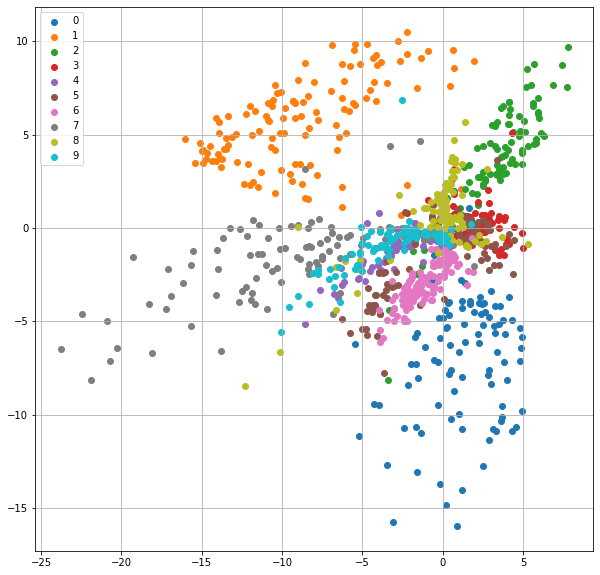

In [25]:
plt.figure(figsize=(10, 10))

for cl in range(10):
    lat_codes_class = lat_codes[labels == cl]
    plt.scatter(lat_codes_class[:, 0], lat_codes_class[:, 1], label=f'{cl}')
plt.legend()
plt.grid()
plt.show()

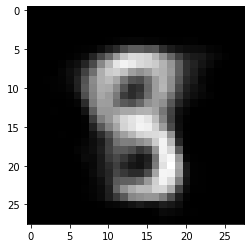

In [33]:
plt.imshow(model_2d.decode(torch.zeros((1, 2), device=device)).squeeze(0).squeeze(0).detach().cpu().numpy(), cmap='gray')

Объекты одного и то же класса находятся в латентном пространстве близко друг к другу! При этом визуально похожие классы (1-4 или 4-9) тоже находятся в соседних областях.

## 4. Применения

### 4.1 Semi-supervised learning

Представим, что у нас следующая ситуация. Есть огромный датасет (тысячи объектов), но по тем или иным причинам размечена у него только малая часть (скажем, сотня) объектов. Например, причиной может быть дороговизна разметки или необходимость привлечения эксперта. Однако, мы хотим научиться решать эту задачу и должны как-то научиться использовать неразмеченные данные.

В такой ситуации можно обучить автоэнкодер на всем датасете (размеченные + неразмеченные объекты) и использовать его латентные коды от размеченных объектов для обучения другой модели (например, из классического ML), которая не требовательна к объему данных.

In [34]:
# предположим, у нас размечено только 1000 (из 50000) объектов из MNIST
# возьмем для них латентные коды

train_lat_codes, train_labels = get_latent_codes_and_labels(dataloader_train, model, 1000)

assert train_lat_codes.shape == (1000, 8)
assert train_labels.shape == (1000, )

# так же обсчитаем весь валидационный сет
test_lat_codes, test_labels = get_latent_codes_and_labels(dataloader_valid, model, 10000)

assert test_lat_codes.shape == (10000, 8)
assert test_labels.shape == (10000, )

In [35]:
# обучим на них случайный лес
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier()
clf.fit(train_lat_codes, train_labels)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [36]:
test_pred = clf.predict(test_lat_codes)

In [37]:
print(f'Test accuracy: {(test_pred == test_labels).mean()}')

Test accuracy: 0.834


Довольно хорошее качество для такого малого объема размеченных данных. Кроме того, мы смогли совместить преимущества нейросетевого и классического подхода и взять от них самое лучшее (нетребовательность к данным от ML и способность работы со сложноструктурированными данными от DL).

Своего рода, это частный случай fine-tuning для ситуации, когда исходная сетка (энкодер) обучалась на неразмеченных данных.

### 4.2 Denoising

Кроме того, автоэнкодеры часто используют для очистки исходных данных от шума. Латентный код сохраняет только главную информацию об объекте, отбрасывая шумовые компоненты. 

Давайте реализуем функцию, которая обращает c вероятностью 0.1 каждый пиксель исходного изображения, и обучим на такой выборке автоэнкодер.

In [38]:
class FlipRandomPixels:
    def __init__(self, flip_ratio=0.1):
        self.flip_ratio = flip_ratio
        
    def __call__(self, x):
        mask = torch.rand_like(x) > self.flip_ratio
        x = torch.where(mask, x, 1 - x)
        
        return x

transform = transforms.Compose([
    transforms.ToTensor(), 
    FlipRandomPixels(),
])

dataset_train_with_noise = torchvision.datasets.MNIST(root=data_root, train=True, transform=transform)
dataloader_train_with_noise = torch.utils.data.DataLoader(dataset_train_with_noise, batch_size=64, shuffle=True, num_workers=1)

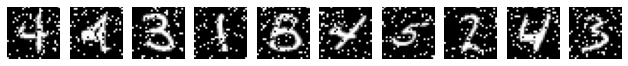

In [39]:
for x, y in dataloader_train_with_noise:
    break

plt.figure(figsize=(11, 1))

for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.axis('off')
    plt.imshow(x[i, 0].cpu().detach().numpy(), cmap='gray')

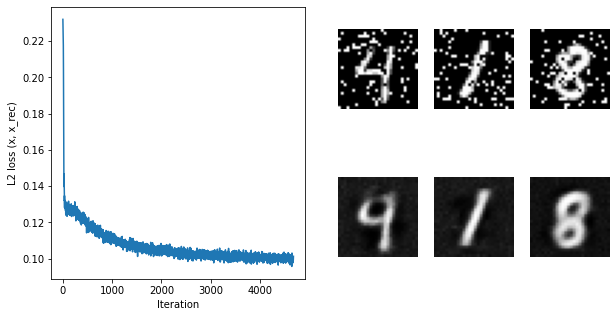

In [40]:
# обучим автоэнкодер на зашумленных данных

model_for_noise = AutoEncoder(8)
model_for_noise.to(device)
optimizer = torch.optim.Adam(model_for_noise.parameters(), lr=1e-3)

train_model(model_for_noise, dataloader_train_with_noise, optimizer, criterion)

Восстановленные объекты не содержат шума, которым мы испортили данные! 

Этот эксперимент должен Вам напомнить метод главных компонент (PCA) из классического ML, который тоже часто используют для сжатия данных и избавления от шума. PCA является частным случаем автоэнкодера с линейными энкодером и декодером.

Acknowledgements: этот ноутбук основан на [восьмом семинаре](https://github.com/hse-ds/iad-deep-learning/blob/b958bd1/sem08/sem08.ipynb) курса ИАД DL.